In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
# import datetime
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)
conn = engine.connect()

In [5]:
# reflect an existing database into a new model
# inspector = inspect(engine)
# inspector.get_table_names()
Base = automap_base()
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station =  Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
print('measurement:')
for column in columns:
    print(column["name"], column["type"])

columns = inspector.get_columns('station')
print('station')
for column in columns:
    print(column["name"], column["type"])

measurement:
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
for row in session.query(measurement, measurement.date).group_by(measurement.date).order_by(measurement.date.desc()).limit(1):
#     print(row)
    recent_date=row.date
# recent_date
recent_date=datetime.strptime(recent_date, "%Y-%m-%d").date()
recent_date

datetime.date(2017, 8, 23)

<function matplotlib.pyplot.show(close=None, block=None)>

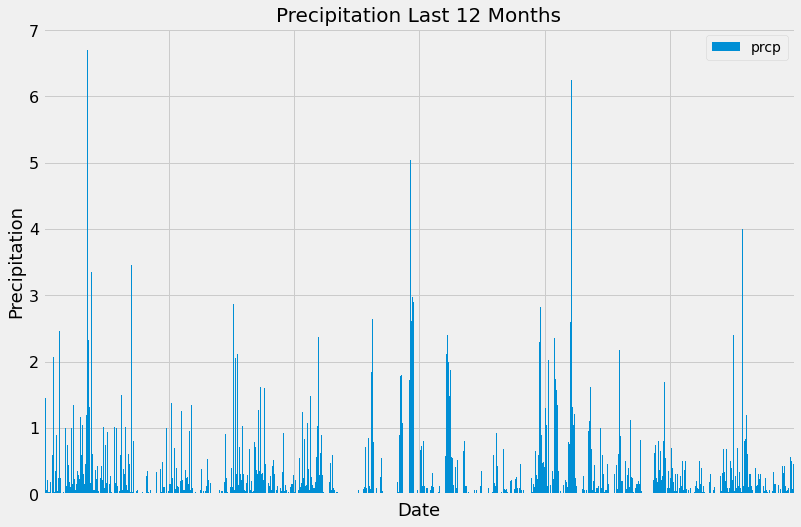

In [21]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# print(recent_date)
# Calculate the date one year from the last date in data set.
lydate = (recent_date - relativedelta(years=1))
# print(lydate)
# Perform a query to retrieve the data and precipitation scores
prcp_score = session.query(measurement.date, measurement.prcp).filter(measurement.date > lydate).all()
prcp_score

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_score_df = pd.DataFrame(prcp_score, columns=['date', 'prcp']).fillna(0)
prcp_score_df

# Sort the dataframe by date
prcp_score_df = prcp_score_df.sort_values('date', ascending=True)
prcp_score_df
# Use Pandas Plotting with Matplotlib to plot the data

ax = prcp_score_df.plot(kind='bar', width=3, figsize=(12,8))
ax.locator_params(axis='x', nbins=6)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.tick_params(axis='y', labelsize=16)
ax.grid(True)
plt.title("Precipitation Last 12 Months", size=20)
plt.ylabel("Precipitation", size=18)
plt.xlabel("Date", size=18)
plt.show

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_score_df.describe()

,prcp
count,2223.000000
mean,0.159951
std,0.441220
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number stations in the dataset
num_station = session.query(station).count()
print(f"Total of {num_station} stations found.")

Total of 9 stations found.


In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
sel = [measurement.station, func.count(measurement.station)]
station_count = session.query(*sel).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_df = pd.DataFrame(station_count, columns=['station', 'count'])
most_active_station = station_df['station'][0]
most_active_station

sel = [measurement.station, func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)]
station_stats = session.query(*sel).filter(measurement.station == most_active_station).group_by(measurement.station).all()
df = pd.DataFrame(station_stats, columns=['station', 'min temp', 'max temp', 'avg temp'])
df

,station,min temp,max temp,avg temp
0,USC00519281,54.0,85.0,71.663781


<function matplotlib.pyplot.show(close=None, block=None)>

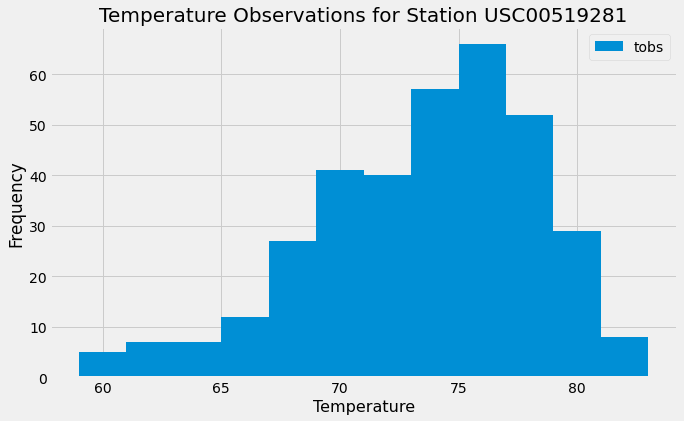

In [33]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_data = session.query(measurement.date, measurement.tobs).filter(measurement.station == most_active_station).\
    filter(measurement.date > lydate).all()
station_data
station_data_df = pd.DataFrame(station_data, columns=['station', 'tobs'])
station_data_df.set_index('station', inplace=True)
station_data_df.plot.hist(by='date', bins=12, figsize=(10, 6))
plt.grid(True)
plt.title(f"Temperature Observations for Station {most_active_station}" , fontsize=20)
plt.xlabel("Temperature", fontsize=16)
plt.show

# Close session

In [32]:
# Close Session
session.close()